In [5]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

In [56]:
def make_canonical_element(indices: list[int], n: int) -> np.array:
	""" 
		Construct the element of the canonical basis for a tensor of order len(indices), in dimension n. 
		indices are the indices of the canonical element
	"""
	x = np.zeros([n for _ in range(len(indices))])
	x[tuple(indices)] =1
	return x

In [57]:
def shuffle_product(left: list[int], right: list[int], n: int) -> list[np.array]:
	"""
		Perform the shuffle product between two signature basis

		left, right: "word", i.e. any element of the canonical basis of any tensor of any order, with dimension equal to n.
		n: dimension of the tensors
	"""
	
	if len(left) == 0:
		return make_canonical_element(right, n)
	elif len(right) == 0:
		return make_canonical_element(left, n)
	
	(begin_left, last_left) = left[:-1], left[-1]
	(begin_right, last_right) = right[:-1], right[-1]

	sub_left = shuffle_product(begin_left, right, n)
	sub_right = shuffle_product(left, begin_right, n)

	return (
		np.tensordot(sub_left, make_canonical_element([last_left], n), axes=0) +
		np.tensordot(sub_right, make_canonical_element([last_right], n), axes=0)
	)

In [65]:
def decompose_shuffle_result(shuffle_result: np.array) -> list[tuple[int]]:
	"""
		Given the result of some shuffle product, return the indices of the individual basis element that composes it
	"""
	return list(filter(
		lambda x: abs(shuffle_result[x] - 1) < 1e-6,
		np.ndindex(shuffle_result.shape)
	))

In [28]:
def generate_ornstein_uhlenbeck(t0, t1, x0, kappa, etha, theta, n_divs, n_curves):
	brownian_diffs = npr.normal( 0.0, 1.0, size=(n_curves, n_divs))
	process = np.zeros( (n_curves, n_divs) )
	dt = (t1-t0)/n_divs
	process[:, 0] = x0
	for i in range(1, process.shape[1]):
		process[:, i] = process[:, i-1] + kappa * (theta - process[:, i-1]) * dt + np.sqrt(dt)*etha*brownian_diffs[:, i]

	return process

In [51]:
def generate_brownian(t0, t1, n_divs, n_curves):
	return np.cumsum(np.concatenate(
		(np.zeros((n_curves, 1)), np.sqrt( (t1-t0) / n_divs) * npr.normal(0, 1, (n_curves, n_divs)) ),
		axis=1
	), axis=1)

In [132]:
def compute_signature( x: np.ndarray, trunc: int ):
	assert trunc >= 2
	n_divs, dim = x.shape[1], x.shape[0]
	signature = [np.ones(n_divs), x]
	for n in range(2, trunc+1):
		shape_n = tuple([dim for _ in range(n)])
		sig_n = np.zeros( shape=shape_n+(n_divs,) )
		for index in np.ndindex(shape_n):
			integrals = np.zeros(n_divs)
			for i in range(n_divs-1):
				integrals[i+1] = signature[n-1][(index[:-1] + (i,))] * (x[index[-1], i+1] - x[index[-1], i])
			sig_n[index] = integrals.cumsum()
		signature.append(sig_n)
	return signature

In [ ]:
n = 1000
x0 = 0.0
t0, t1 = 0.0, 1.0
kappa, theta, etha = 1.0, 0.25, 1.2

In [145]:
brownian = generate_brownian(t0, t1, n, 1).flatten()
times = np.arange(n+1) / n
signature = compute_signature( np.array([times, brownian]), 4)

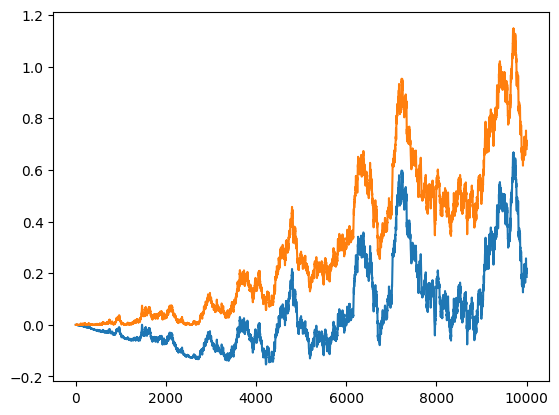

In [146]:
plt.plot(signature[2][1,1])
t = np.arange(101) / 100.0
plt.plot( brownian*brownian*0.5)

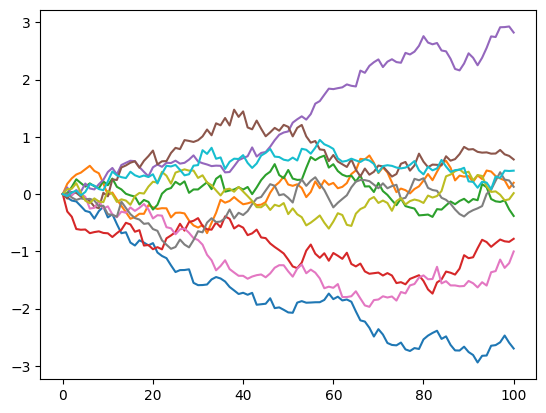

In [53]:
process = generate_ornstein_uhlenbeck(t0, t1, x0, kappa, etha, theta, n, 10)
brownians = generate_brownian(t0, t1, 100, 10)
_ = plt.plot(brownians.transpose())